In [2]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, Bidirectional, BatchNormalization, TextVectorization, Layer, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision
import tensorflow.keras.backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from scripts.processing import *

# Load the TensorBoard notebook extension
%load_ext tensorboard



2.8.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
# The maximum number of words to be used. (most frequent)
vocab_size = 100000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each review.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [26]:
# load the dataset and use the first 500k (to be faster on testruns)

dfr = pd.read_csv('../data/yelp_dataset/review_1819.csv')
dfr = dfr[:400000]


In [27]:
# drop geo outlier businesses 
dfr.drop(dfr[(dfr.business_id == 'wKwCbAACZRAqyZkQzeBNeg')].index, inplace=True)
dfr.drop(dfr[(dfr.business_id == 'g0fYqQRRKmYIfChE4jMLsg')].index, inplace=True)

In [28]:
# reduce dataset to text and rating
dataset = dfr[['text', 'useful']]

In [29]:
# filter for only english reviews and remove the language line used for filtering
dataset = language_processing(dfr)
dataset.drop('language', axis=1, inplace=True)

#apply function for textcleaning and make sure everything looks as planned
dataset["text"] = dataset["text"].apply(clean_text)

In [30]:
# define feature and target
review = dataset[['text']]
target = dataset["useful"].apply(lambda x: 1 if x > 0 else 0).values

# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(review, target, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(284030, 1) (284030,)
(71008, 1) (71008,)


In [31]:
#apply tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 132409 unique tokens.


In [32]:
# transform feature to tensors and pad for better comparison
train_seq = tokenizer.texts_to_sequences(X_train['text'])
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(X_test['text'])
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of train tensor:', train_padded.shape)
print('Shape of validation tensor:', test_padded.shape)

Shape of train tensor: (284030, 200)
Shape of validation tensor: (71008, 200)


In [33]:
#initiate labels for target
training_labels = y_train
test_labels = y_test

In [35]:
# create a train set with the tokenized text and all the other features
X_train.drop(['text'], axis=1, inplace=True)
train_token = pd.DataFrame(train_padded)
train_con = X_train.reset_index().join(train_token)
train_con.drop(['index'], axis=1, inplace=True)

# do the same steps for the test set
X_test.drop(['text'], axis=1, inplace=True)
test_token = pd.DataFrame(test_padded)
test_con = X_test.reset_index().join(test_token)
test_con.drop(['index'], axis=1, inplace=True)

In [ ]:
vectorize_layer = TextVectorization(
 standardize='lower_and_strip_punctuation', 
 ngrams=3,
 max_tokens=vocab_size,
 output_mode='int',
 output_sequence_length=max_length)

vectorize_layer.adapt(X_test)

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [36]:
# initiate and define the model
text_in = Input(shape=(1,), dtype=tf.string)
vector = vectorize_layer(text_in)
embedding = Embedding(vocab_size, embedding_dim)(vector)
text_bidir_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
text_dropout_1 = Dropout(0.5)(text_bidir_lstm_1)
text_bidir_lstm_2 = Bidirectional(LSTM(128, return_sequences=True))(text_dropout_1)
text_dropout_2 = Dropout(0.5)(text_bidir_lstm_2)
text_attention = attention()(text_dropout_2)
text_dense = Dense(64, activation='relu')(text_attention)
text_batch_norm_1 = BatchNormalization()(text_dense)
text_out = Dropout(0.5)(text_batch_norm_1)

#concat = concatenate([text_out, num_in])
dense_1 = Dense(128, activation='relu')(text_out)
batch_norm_1 = BatchNormalization()(dense_1)
dropout_1 = Dropout(0.5)(batch_norm_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
batch_norm_2 = BatchNormalization()(dense_2)
dropout_2 = Dropout(0.5)(batch_norm_2)

out = Dense(1, activation='sigmoid')(dropout_2)
model = Model(inputs=[text_in], outputs=[out])

In [46]:
#compile the model
model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=['Precision'])

In [48]:
# save history in tensorboard
log_dir = "../logs/new/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback that saves the model's weights
checkpoint_path = "../training/model_5/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [49]:
# set parameters and train the model
epochs = 4
batch_size = 256

history = model.fit(train_con, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[tensorboard_callback, cp_callback])

model.save('../saved_model/model_5')

Epoch 1/4


2022-09-05 15:27:11.911845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 15:27:12.783860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 15:27:13.281198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 15:27:15.842398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 15:27:15.865933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


888/888 [==============================] - ETA: 0s - loss: 0.1293 - precision: 0.7511

2022-09-05 15:32:45.842450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 15:32:46.119607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 15:32:46.135853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ../training/model_5/cp.ckpt
888/888 [==============================] - 362s 399ms/step - loss: 0.1293 - precision: 0.7511 - val_loss: 0.1727 - val_precision: 0.5694
Epoch 2/4
888/888 [==============================] - ETA: 0s - loss: 0.1203 - precision: 0.7796
Epoch 2: saving model to ../training/model_5/cp.ckpt
888/888 [==============================] - 370s 417ms/step - loss: 0.1203 - precision: 0.7796 - val_loss: 0.1785 - val_precision: 0.5585
Epoch 3/4
888/888 [==============================] - ETA: 0s - loss: 0.1102 - precision: 0.8096
Epoch 3: saving model to ../training/model_5/cp.ckpt
888/888 [==============================] - 466s 525ms/step - loss: 0.1102 - precision: 0.8096 - val_loss: 0.2035 - val_precision: 0.5461
Epoch 4/4
888/888 [==============================] - ETA: 0s - loss: 0.1018 - precision: 0.8315
Epoch 4: saving model to ../training/model_5/cp.ckpt
888/888 [==============================] - 506s 570ms/step - loss: 0.1018 - precision: 0

INFO:tensorflow:Assets written to: ../saved_model/model_5/assets


INFO:tensorflow:Assets written to: ../saved_model/model_5/assets


In [50]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_con, test_labels, batch_size=batch_size)

Evaluate on test data
278/278 [==============================] - 43s 154ms/step - loss: 0.2285 - precision: 0.5384


<AxesSubplot:>

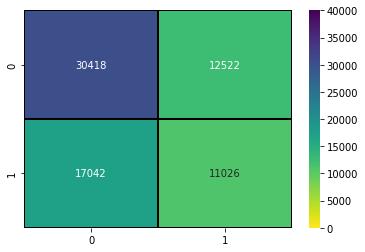

In [54]:
pred_labels = (model.predict(test_con) > 0.5).astype('int32')
sns.heatmap(tf.math.confusion_matrix(test_labels, pred_labels), annot=True, fmt='g', cmap='viridis_r', vmin=0, vmax=40000, linewidth=0.01, linecolor='k')

In [55]:
# show the classification report
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.64      0.71      0.67     42940
           1       0.47      0.39      0.43     28068

    accuracy                           0.58     71008
   macro avg       0.55      0.55      0.55     71008
weighted avg       0.57      0.58      0.58     71008



In [56]:
text_seq = tokenizer.texts_to_sequences(review)
text_padded = pad_sequences(text_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [58]:
dataset['helpfulness'] = model.predict(text_padded)

ValueError: Length of values (1) does not match length of index (355038)

In [ ]:
dataset.sort_values('helpfulness')

In [ ]:
dataset.loc[1414387].text

In [ ]:
dfr['helpfulness'] = dataset['helpfulness']

In [ ]:
dfr_ea = dfr.dropna(axis = 0)

In [ ]:
dfr_ea.loc[170477]

In [ ]:
dfr_ea.query('business_id == "toRNyzwkG59NYJP2ti-qTQ"').sort_values('helpfulness')